In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

#### Loading the Dataset

In [2]:
torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# SD of all pixels should be 1
# 0.5, 0.5, 0.5 -- RGB
# first set of 0.5 0.5 0.5 represents the means of each channel
# second set of 0.5 0.5 0.5 represents the SDs of each channel
# for each pixel value, subtract from it 0.5 (mean; need to get the mean from the training examples) and divide it by 0.5 (dividing so that when we compute the SD, it's going to give us 1)
# the transform function automatically does it, vals between -1 and 1, SD = 1

trainset = datasets.CIFAR10(
    root = '~/Downloads/',
    train = True,
    download = True,
    transform = transform
)
testset = datasets.CIFAR10(
    root = '~/Downloads/',
    train = False,
    download = True,
    transform = transform
)

batchSize = 64
train_dataloader = DataLoader(trainset, batch_size = batchSize, shuffle = True)
test_dataloader = DataLoader(testset, batch_size = batchSize, shuffle = True)

100%|██████████| 170498071/170498071 [00:02<00:00, 75221905.67it/s]


Extracting /root/Downloads/cifar-10-python.tar.gz to /root/Downloads/
Files already downloaded and verified


In [3]:
trainset[0]             # returns X (image) and Y (label)
trainset[0][0]          # image is contained at index 0
trainset.classes        # returns a list of all classes
trainset[0][0].shape    # size of the image is 3 x 32 x 32 (in PyTorch, depth is first), but you need to reshape if you want to view it using plt
                        # instead of all this, we'll use a transformation, normalize it but with -1 instead of the mean and 2 for SD
                        # this will give us back the original image (see next cell)

torch.Size([3, 32, 32])

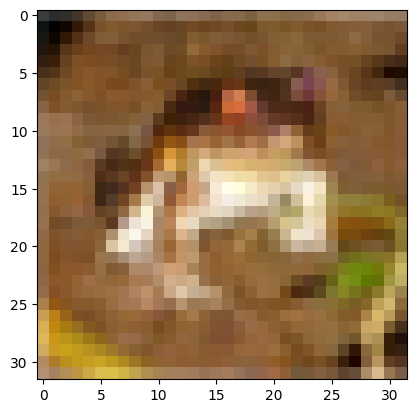

In [4]:
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), transforms.ToPILImage()])
# PIL takes care of changing the shape and the visualization
# without this parameter, shape will be 3 x 32 x 32; matplotlib expects 32 x 32 x 3

plt.imshow(transform_back(trainset[0][0]))

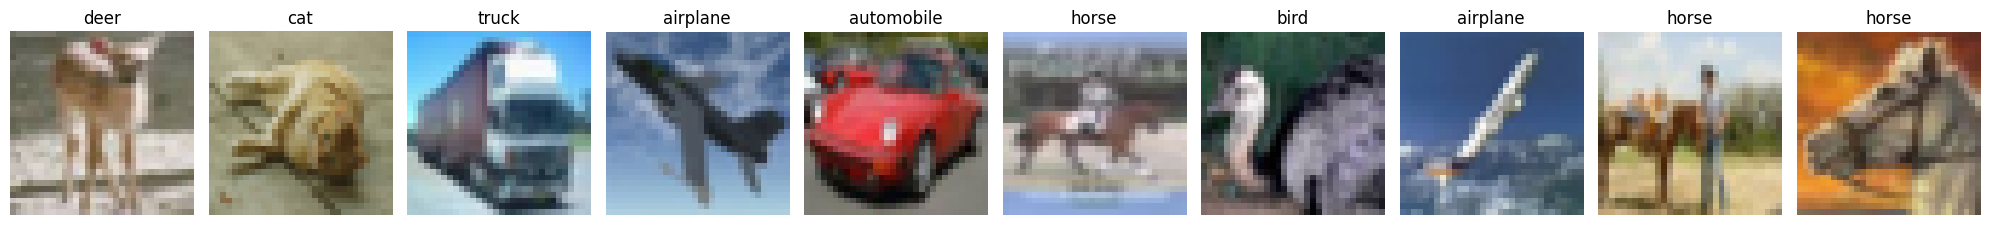

In [5]:
images, labels = next(iter(train_dataloader))                                   # get one batch of training data

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}

plt.figure(figsize = (20, 30))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[labels[i].item()])

plt.tight_layout()
plt.show()

In [6]:
trainset.class_to_idx       # gives you a dictionary where the key is the class and the value is the index
trainset[0][1]              # output: 6 --> first image is a frog

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

#### Follow Along in Class

#### Building a CNN for Classification

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')                               # you'll need to send everything to the 'device'

class MyFirstCNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 3, stride = 1, padding = 1),   # input: 3 x 32 x 32
                                                                                                      # 4 filters of size 3 x 3
                                                                                                      # output: 4 x 32 x 32
            nn.ReLU(),

            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),   # output: 8 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4),                                                # output: 8 x 8 x 8

            nn.Flatten(),                                                                             # flatten it into one vector
            nn.Linear(8*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10),                                                                       # 10 --> 10 classes
                                                                                                      # 2 fully-connected layers (the 2 nn.Linears)
            # nn.LogSoftmax(dim = 1)                                                                  # only needed if you use NLLLoss function
                                                                                                      # if you use CrossEntropy loss, no need
        )

        # it's better to use nn.Sequential rather than defining each layer separately and then applying forward() to each layer
        # here, we're just defining a network and then passing that to the forward function

    def forward(self, x):
        return self.network(x)

In [21]:
model1 = MyFirstCNNModel()
model1.to(device)
print(model1)

MyFirstCNNModel(
  (network): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


#### Training the Neural Network

In [22]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr = 0.001)
train_history = []                                          # both the training and validation loss should decrease with each epoch
validation_history = []

# Training Loop
model1.train()                                               # tell the model that your are training it
                                                            # or you can also do model.eval() instead?
for epoch in range(10):                                     # feeding 64 images in batch at each epoch
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model1(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model1(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(trainset)} | Validation Loss: {val_loss / len(testset)}')
    train_history += [train_loss / len(trainset)]
    validation_history += [val_loss / len(testset)]
print('\nFinished Training')

Epoch [1] --> Training Loss: 0.025817836084365844 | Validation Loss: 0.022571196627616884
Epoch [2] --> Training Loss: 0.021670630724430085 | Validation Loss: 0.020864504384994507
Epoch [3] --> Training Loss: 0.019782655832767487 | Validation Loss: 0.019675650441646576
Epoch [4] --> Training Loss: 0.018339747656583787 | Validation Loss: 0.019053308486938477
Epoch [5] --> Training Loss: 0.017175810614824295 | Validation Loss: 0.01796221805214882
Epoch [6] --> Training Loss: 0.01631639460802078 | Validation Loss: 0.017433612871170043
Epoch [7] --> Training Loss: 0.015564963384866714 | Validation Loss: 0.016817267113924027
Epoch [8] --> Training Loss: 0.014944073243141174 | Validation Loss: 0.016559040600061418
Epoch [9] --> Training Loss: 0.014379231085777282 | Validation Loss: 0.016684312576055526
Epoch [10] --> Training Loss: 0.013902219305038451 | Validation Loss: 0.01615940138101578

Finished Training


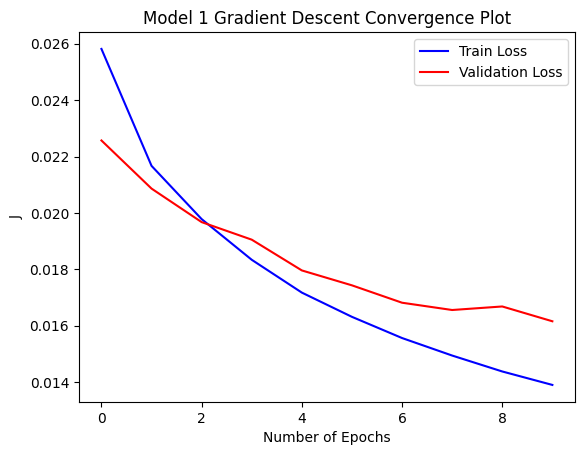

In [23]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 1 Gradient Descent Convergence Plot')
plt.show()

#### Testing the Neural Network

Actual: automobile 		 Predicted: automobile
Actual: truck 		 Predicted: deer
Actual: bird 		 Predicted: deer
Actual: frog 		 Predicted: deer
Actual: frog 		 Predicted: frog
Actual: cat 		 Predicted: bird
Actual: ship 		 Predicted: ship
Actual: automobile 		 Predicted: automobile
Actual: horse 		 Predicted: horse
Actual: bird 		 Predicted: bird


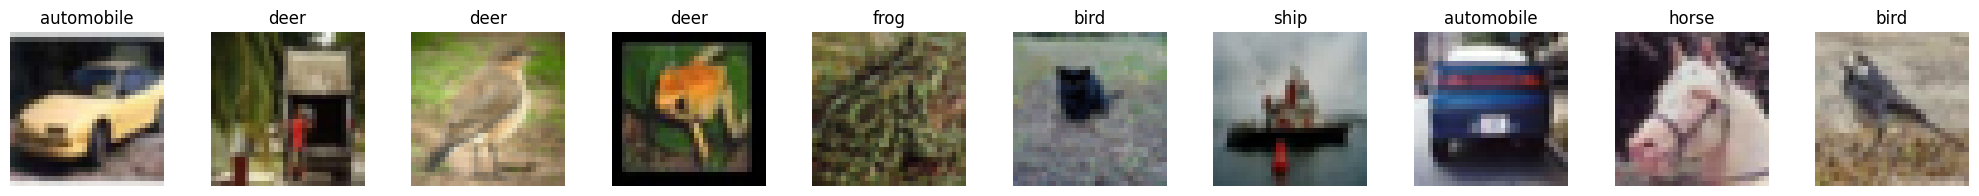

In [24]:
images, labels = next(iter(test_dataloader))              # takes one batch of testing data
images = images.to(device)
labels = labels.to(device)

outputs = model1(images)
_, predicted = torch.max(outputs, dim = 1)                # gives us the index of the max value along the specified dimension

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the Network (Model 1) on the 10000 Test Images: {100 * correct / total}%')

Accuracy of the Network (Model 1) on the 10000 Test Images: 64.28%


#### Pop Quiz 5
*   ksize = 3 x 3 , padding = 1 , stride = 1
*   max pooling , ksize = 2 , stride = 2

*   Neural Network
    * 32 Conv Filter -- Relu -- 64 Conv Filter -- Relu -- Max Pool
    * 256 Conv Filter -- Relu -- 256 Conv Filter -- Relu -- Max Pool
    * 128 Conv Filter -- Relu -- 128 Conv Filter -- Relu -- Max Pool
    * 1024 -- Relu -- 512 -- Relu -- 10





In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MySecondCNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        return self.network(x)

In [27]:
model2 = MySecondCNNModel()
model2.to(device)
print(model2)

MySecondCNNModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=2048, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [28]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
train_history = []
validation_history = []

# Training Loop
model2.train()

for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model2(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # Validation
    with torch.no_grad():
        val_loss = 0
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model2(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(trainset)} | Validation Loss: {val_loss / len(testset)}')
    train_history += [train_loss / len(trainset)]
    validation_history += [val_loss / len(testset)]
print('\nFinished Training')

Epoch [1] --> Training Loss: 0.024375632990598677 | Validation Loss: 0.019533246606588364
Epoch [2] --> Training Loss: 0.015920511301755907 | Validation Loss: 0.014330322617292404
Epoch [3] --> Training Loss: 0.012327839670777321 | Validation Loss: 0.01219911801815033
Epoch [4] --> Training Loss: 0.010031768597364425 | Validation Loss: 0.010910288792848588
Epoch [5] --> Training Loss: 0.0082070866638422 | Validation Loss: 0.01071420606970787
Epoch [6] --> Training Loss: 0.0067606839352846145 | Validation Loss: 0.01034104903936386
Epoch [7] --> Training Loss: 0.0054758349345624445 | Validation Loss: 0.010862576454877853
Epoch [8] --> Training Loss: 0.0044134184780716896 | Validation Loss: 0.01093353097140789
Epoch [9] --> Training Loss: 0.003537499338835478 | Validation Loss: 0.012939752021431923
Epoch [10] --> Training Loss: 0.0030540831627696753 | Validation Loss: 0.013849367007613182

Finished Training


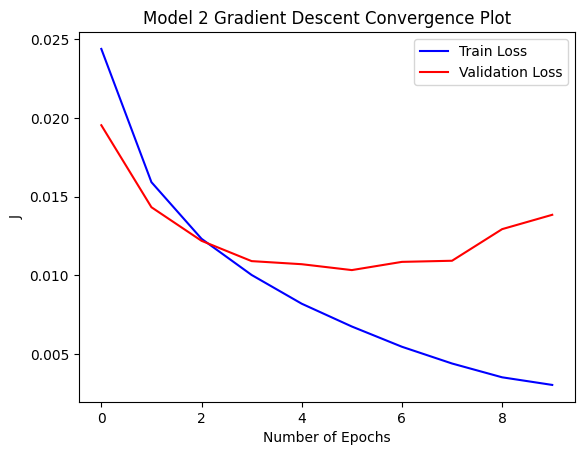

In [29]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model 2 Gradient Descent Convergence Plot')
plt.show()

Actual: airplane 		 Predicted: airplane
Actual: bird 		 Predicted: frog
Actual: bird 		 Predicted: bird
Actual: airplane 		 Predicted: airplane
Actual: frog 		 Predicted: frog
Actual: ship 		 Predicted: ship
Actual: truck 		 Predicted: truck
Actual: dog 		 Predicted: dog
Actual: horse 		 Predicted: horse
Actual: horse 		 Predicted: horse


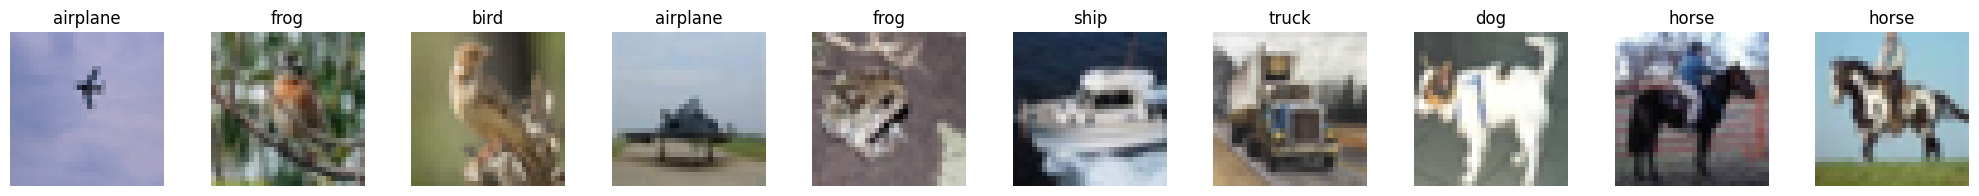

In [30]:
images, labels = next(iter(test_dataloader))              # takes one batch of testing data
images = images.to(device)
labels = labels.to(device)

outputs = model2(images)
_, predicted = torch.max(outputs, dim = 1)                # gives us the index of the max value along the specified dimension

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the Network (Model 2) on the 10000 Test Images: {100 * correct / total}%')

Accuracy of the Network (Model 2) on the 10000 Test Images: 78.68%
